# Check Spark configuration

In [1]:
from pyspark import SparkConf
SparkConf().getAll()

[('spark.driver.memory', '20g'),
 ('spark.executor.memory', '10g'),
 ('spark.submit.deployMode', 'client'),
 ('spark.executor.memoryOverhead', '10g'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.master', 'local[2]'),
 ('spark.driver.maxResultSize', '5g')]

# Data Engineering

## Read Data

Twitter data source is available from http://help.sentiment140.com/for-students

In [2]:
from pyspark.sql.functions import col
df = spark.read.csv('trainingandtestdata/training.1600000.processed.noemoticon.csv')
df = df.select(col('_c5').alias('text'), col('_c0').alias('target'))

In [3]:
df.show()

+--------------------+------+
|                text|target|
+--------------------+------+
|@switchfoot http:...|     0|
|is upset that he ...|     0|
|@Kenichan I dived...|     0|
|my whole body fee...|     0|
|@nationwideclass ...|     0|
|@Kwesidei not the...|     0|
|         Need a hug |     0|
|@LOLTrish hey  lo...|     0|
|@Tatiana_K nope t...|     0|
|@twittera que me ...|     0|
|spring break in p...|     0|
|I just re-pierced...|     0|
|@caregiving I cou...|     0|
|@octolinz16 It it...|     0|
|@smarrison i woul...|     0|
|@iamjazzyfizzle I...|     0|
|Hollis' death sce...|     0|
|about to file taxes |     0|
|@LettyA ahh ive a...|     0|
|@FakerPattyPattz ...|     0|
+--------------------+------+
only showing top 20 rows



## Clean data
* remove url link
* remove @mention, \#hashTag, <word\>
* remove [\*] with one word included, such as [-o], [twitter], [*.com]
* remove \$ + number, such as $12,000
* remove words having special unicode character, such as U+FFFD
* string lower case, strip spaces
* html unquote, such as transforming &amp\; to &;
* replace sad face: replace "=\[", "=\(", ":(", ":-\[", ":\[" by "sad"
* replace happy face: replace ":)", ": )", ":\]" by "happy"
* replace "'s " by " is "
* replace *'t into two words, such as don't -> do not
* keep only letters [a-zA-Z]
* drop Null data

In [4]:
from pyspark.sql.functions import regexp_replace, udf
from pyspark.sql.types import StringType
import html
import re
df = df.withColumn('text', regexp_replace('text', 'https?://[\w\d./_?=]+', ''))
df = df.withColumn('text', regexp_replace('text', 'www.[\w\d./_?=]+', ''))
df = df.withColumn('text', regexp_replace('text', "\@[\w\d.'_]+", ''))
df = df.withColumn('text', regexp_replace('text', "\#[\w\d.'_]+", ''))
df = df.withColumn('text', regexp_replace('text', "\<[\w]+\>+", ''))
df = df.withColumn('text', regexp_replace('text', "\[[\S\w\d:.-]+\]", ''))
df = df.withColumn('text', regexp_replace('text', "\$\d+,? ?\d*", ''))
df = df.withColumn('text', regexp_replace('text', "(=\[|=\(|:\-\[|:\[)", 'sad'))
df = df.withColumn('text', regexp_replace('text', "(: ?\)|: ?\])", 'happy'))
df = df.withColumn('text', regexp_replace('text', "'s ", ' is '))

dataClean = udf(lambda x: html.unescape(x).lower().strip(), StringType())
#removeUnicode = udf(lambda x: re.sub("[\w]*"+u"\uFFFD ?"+ "([\w]+|$)", "", x), StringType())
removeUnicode = udf(lambda x: "".join(i for i in x if ord(i)<128))
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",   
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
@udf(StringType())
def negations(s):
    for key in negations_dic:
        s = re.sub(key, negations_dic[key], s) 
    return s
stripWord = udf(lambda x: x.strip(), StringType())

df = df.withColumn('text', dataClean(col('text')) )
df = df.withColumn('text', removeUnicode(col('text')) )
df = df.withColumn('text', negations(col('text')) )
df = df.withColumn('text', regexp_replace('text', "[^a-zA-Z]", ' '))
df = df.withColumn('text', stripWord(col('text')))
df = df.dropna('any')

In [5]:
df.show()

+--------------------+------+
|                text|target|
+--------------------+------+
|awww  that is a b...|     0|
|is upset that he ...|     0|
|i dived many time...|     0|
|my whole body fee...|     0|
|no  it is not beh...|     0|
|  not the whole crew|     0|
|          need a hug|     0|
|hey  long time no...|     0|
|nope they did not...|     0|
|        que me muera|     0|
|spring break in p...|     0|
|i just re pierced...|     0|
|i could not bear ...|     0|
|it it counts  idk...|     0|
|i would ve been t...|     0|
|i wish i got to w...|     0|
|hollis  death sce...|     0|
| about to file taxes|     0|
|ahh ive always wa...|     0|
|oh dear  were you...|     0|
+--------------------+------+
only showing top 20 rows



## Split train / test / validation data
* train:        90%
* validation:   5%
* test:         5%

In [6]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, NGram
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

(train_set, val_set, test_set) = df.randomSplit([0.90, 0.05, 0.05])

## Feature extraction
### Pipeline
* Stop Word Remover
* N Gram model
* TF-IDF

After some hands-on tests, stopWordRemover looks not be a good choice, remove it

In [10]:
tokenizer = Tokenizer(inputCol="text", outputCol="word")
remover = StopWordsRemover(inputCol="word", outputCol="filteredWord")
ngram = NGram(n=2, inputCol="word", outputCol="words")
hashtf = HashingTF(numFeatures = 2**18, inputCol="words", outputCol="tf")
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=2)
label_stringIdx = StringIndexer(inputCol="target", outputCol="label")
pipeline = Pipeline(stages=[tokenizer, remover, ngram, hashtf, idf, label_stringIdx])

pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
val_df = pipelineFit.transform(val_set)

## Logistic Regression

In [11]:
lr = LogisticRegression(maxIter=100, threshold=0.5)
lrModel = lr.fit(train_df)
predictions = lrModel.transform(val_df)

## Validate result
* PySpark use F1-Score by default to validate result. 
* The validation result is about 74%. 

In the next step we use train and validation data to tune hyper parameters

In [12]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='label')
print("Evaluator Metrics is %s" %evaluator.getMetricName())

pred = evaluator.evaluate(predictions) 
print("Prediction is {}".format(pred))

Evaluator Metrics is f1
Prediction is 0.7417493071940593


## Optimize hyper parameters
* Use Gaussian Process to tune hyper parameters
* Hyper parameter list
    * No. of gram = $[2, 3]$
    * No. of TF-IDF features = $[2^{18}, 2^{19}, 2^{20}, 2^{21}, 2^{22}, 2^{23}, 2^{24}]$
    * Minimum doc frequency = $[2, 3, 4, 5]$
    * Logistic regression model threshold = $[0.3, 0.4, 0.5, 0.6, 0.7]$

In [8]:
import skopt
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args

dim_n1 = Integer(low=2, high=3, name='n1')
dim_n2 = Integer(low=18, high=22, name='n2')
dim_n3 = Integer(low=2, high=6, name='n3')
dim_n4 = Integer(low=3, high=7, name='n4')
dimensions = [dim_n1, dim_n2, dim_n3, dim_n4]
default_params = [2, 18, 2, 3]

@use_named_args(dimensions=dimensions)
def sentiment_model(n1, n2, n3, n4):
    tokenizer = Tokenizer(inputCol="text", outputCol="word")
    #remover = StopWordsRemover(inputCol="word", outputCol="filteredWord")
    ngram = NGram(n=int(n1), inputCol="word", outputCol="words")
    hashtf = HashingTF(numFeatures = 2**int(n2), inputCol="words", outputCol="tf")
    idf = IDF(inputCol='tf', outputCol="features", minDocFreq=int(n3))
    label_stringIdx = StringIndexer(inputCol="target", outputCol="label")
    pipeline = Pipeline(stages=[tokenizer, ngram, hashtf, idf, label_stringIdx])

    pipelineFit = pipeline.fit(train_set)
    train_df = pipelineFit.transform(train_set)
    val_df = pipelineFit.transform(val_set)
    
    lr = LogisticRegression(maxIter=100, threshold=n4*0.1)
    lrModel = lr.fit(train_df)
    predictions = lrModel.transform(val_df)
    
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='label')
    res = -evaluator.evaluate(predictions) 
    print("n-gram=%s,   TF-features=2**%s,   minimum-doc-freq=%s,   threshold=%.2f,   prediction=%.4f" %(n1,n2,n3,n4*0.1,-res))
    
    return res

In [9]:
search_result = gp_minimize(func=sentiment_model, 
                            dimensions=dimensions, 
                            acq_func='EI',         # Expected Improvement
                            n_calls = 30,
                            x0=default_params) 

n-gram=2,   TF-features=2**18,   minimum-doc-freq=2,   threshold=0.30,   prediction=0.7274
n-gram=2,   TF-features=2**21,   minimum-doc-freq=5,   threshold=0.60,   prediction=0.7460
n-gram=3,   TF-features=2**21,   minimum-doc-freq=3,   threshold=0.40,   prediction=0.6778
n-gram=3,   TF-features=2**20,   minimum-doc-freq=3,   threshold=0.60,   prediction=0.6615
n-gram=3,   TF-features=2**21,   minimum-doc-freq=3,   threshold=0.40,   prediction=0.6778
n-gram=3,   TF-features=2**18,   minimum-doc-freq=5,   threshold=0.60,   prediction=0.6874
n-gram=3,   TF-features=2**19,   minimum-doc-freq=4,   threshold=0.50,   prediction=0.6487
n-gram=2,   TF-features=2**19,   minimum-doc-freq=4,   threshold=0.30,   prediction=0.7011
n-gram=2,   TF-features=2**20,   minimum-doc-freq=6,   threshold=0.70,   prediction=0.7401
n-gram=2,   TF-features=2**20,   minimum-doc-freq=2,   threshold=0.50,   prediction=0.6777
n-gram=2,   TF-features=2**18,   minimum-doc-freq=3,   threshold=0.40,   prediction=0.7410

C:\Users\linzh\AppData\Local\Continuum\anaconda3\envs\spark\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


n-gram=2,   TF-features=2**22,   minimum-doc-freq=6,   threshold=0.70,   prediction=0.7542
n-gram=3,   TF-features=2**22,   minimum-doc-freq=2,   threshold=0.70,   prediction=0.6878
n-gram=2,   TF-features=2**22,   minimum-doc-freq=4,   threshold=0.30,   prediction=0.7274
n-gram=3,   TF-features=2**20,   minimum-doc-freq=6,   threshold=0.70,   prediction=0.6650


C:\Users\linzh\AppData\Local\Continuum\anaconda3\envs\spark\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


n-gram=2,   TF-features=2**22,   minimum-doc-freq=6,   threshold=0.70,   prediction=0.7542


C:\Users\linzh\AppData\Local\Continuum\anaconda3\envs\spark\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


n-gram=2,   TF-features=2**21,   minimum-doc-freq=6,   threshold=0.70,   prediction=0.7495
n-gram=2,   TF-features=2**19,   minimum-doc-freq=6,   threshold=0.70,   prediction=0.7272
n-gram=2,   TF-features=2**21,   minimum-doc-freq=4,   threshold=0.70,   prediction=0.7203


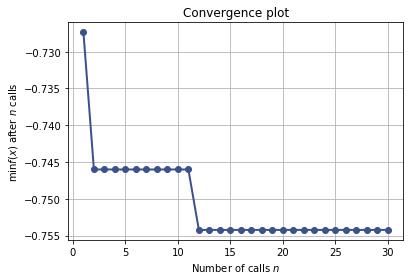

In [15]:
import matplotlib.pyplot as plt
from skopt.plots import plot_convergence
plot_convergence(search_result)
plt.show()

In [16]:
search_result.x

[2, 22, 6, 7]